## Index

1. [EDA](#EDA)
    - [Data Visualization](#Data-Visualization)
2. [Feature Selection](#Feature-Selection)
3. [Encoding](#Encoding)


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [112]:
import pathlib
import os
import sys

sys.path.append(str(pathlib.Path(os.getcwd()).resolve().parent))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from config import config
from src.preprocessing import preprocessors
from src import utils

# EDA

In [99]:
train_data = pd.read_parquet(config.TRAIN_DATASET_RAW)
test_data = pd.read_parquet(config.TEST_DATASET_RAW)

In [4]:
train_data.shape, test_data.shape

((82644, 20), (19790, 19))

Checking the datatype for all the columns in the train dataset: 

In [18]:
train_data.dtypes

hash_0     int64
hash_1     int64
hash_2     int64
hash_3     int64
hash_4     int64
hash_5     int64
hash_6     int64
hash_7     int64
hash_8     int64
hash_9     int64
hash_10    int64
hash_11    int64
hash_12    int64
hash_13    int64
hash_14    int64
hash_15    int64
hash_16    int64
hash_17    int64
hash_18    int64
click      int64
dtype: object

Checking the training dataset for any Missing / NaN values

In [19]:
train_data.isna().sum()

hash_0     0
hash_1     0
hash_2     0
hash_3     0
hash_4     0
hash_5     0
hash_6     0
hash_7     0
hash_8     0
hash_9     0
hash_10    0
hash_11    0
hash_12    0
hash_13    0
hash_14    0
hash_15    0
hash_16    0
hash_17    0
hash_18    0
click      0
dtype: int64

Checking the distribution of labels across different featrures:  

### Data Visualization

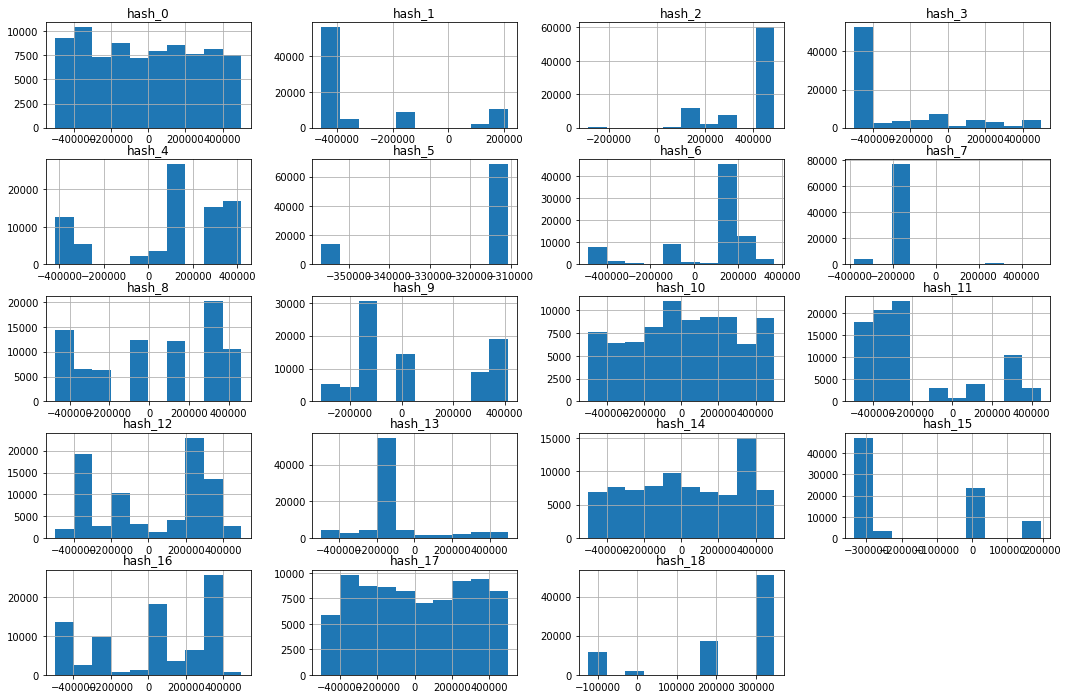

In [20]:
_ = train_data.drop(columns="click").hist(figsize=(18, 12))
plt.show()

From the plots, we can surmize that : -
- hash_5 seems to be a binary label. 
- hash_0, hash_10, hash_14 and hash_17 seem to categorical variables of high cardinality. 

This can be verified by looking at the distinct values in each column in the dataset. 

In [21]:
for col in train_data.columns:
    print(f"ColName : {col}, Unique Values : {train_data[col].nunique()}")
    print("==========")

ColName : hash_0, Unique Values : 7323
ColName : hash_1, Unique Values : 9
ColName : hash_2, Unique Values : 11
ColName : hash_3, Unique Values : 381
ColName : hash_4, Unique Values : 10
ColName : hash_5, Unique Values : 2
ColName : hash_6, Unique Values : 14
ColName : hash_7, Unique Values : 12
ColName : hash_8, Unique Values : 14
ColName : hash_9, Unique Values : 9
ColName : hash_10, Unique Values : 3740
ColName : hash_11, Unique Values : 40
ColName : hash_12, Unique Values : 1478
ColName : hash_13, Unique Values : 103
ColName : hash_14, Unique Values : 34273
ColName : hash_15, Unique Values : 9
ColName : hash_16, Unique Values : 470
ColName : hash_17, Unique Values : 14158
ColName : hash_18, Unique Values : 5
ColName : click, Unique Values : 2


Checking the distribution of categoroical feature values across datapoints where **click** = 0 and **click** = 1. This helps in identifying any feature of interest where 

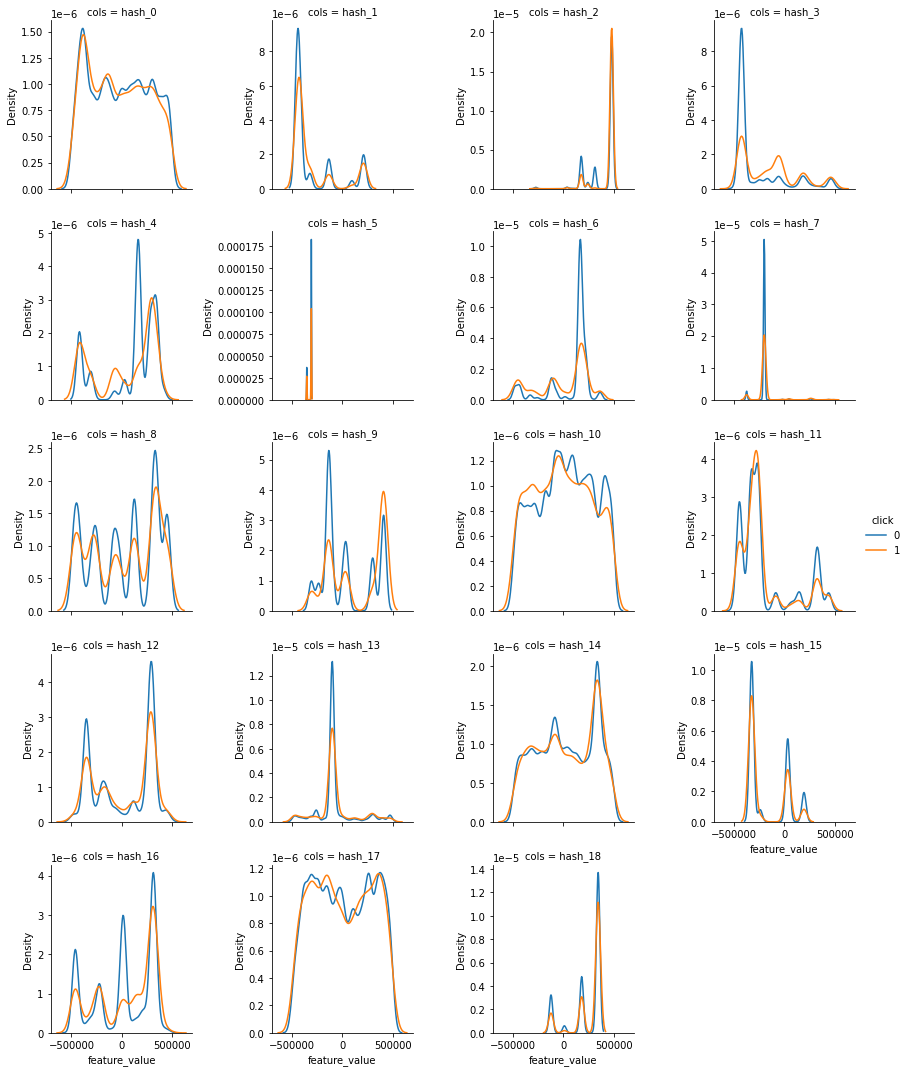

In [22]:
tmp = train_data.melt(["click"], var_name="cols", value_name="feature_value")
g = sns.FacetGrid(tmp, col="cols", hue="click", col_wrap=4, sharey=False)
g = g.map(sns.distplot, "feature_value", hist=False, rug=False)
g.add_legend()

There doesn't seem to be a significant difference in distribution across categories for click values **0** and **1** for any feature in the train dataset

To identify data distribution for features across train and test data, the two datasets can be combined together with a new column identifying a record belonging to either **test** or **train** dataset.

Ideally, the distribution of features across **train** and **test** should be similar, such that feature distributions learnt during the training phase are an accurate representation of the feature distribution that will be encountered in production, or in **test**. 
If a feature is not identically distributed across both **train** and **test**, then a model trained on that feature in **train** might not be able to generalize well enough on the datapoints in the **test** dataset. 

In [23]:
train_data["ds"] = "train"
test_data["ds"] = "test"

combined_data = pd.concat([train_data.drop(columns="click"), test_data]).reset_index(
    drop=True
)

combined_data_long = combined_data.melt(
    ["ds"], var_name="cols", value_name="feature_value"
)

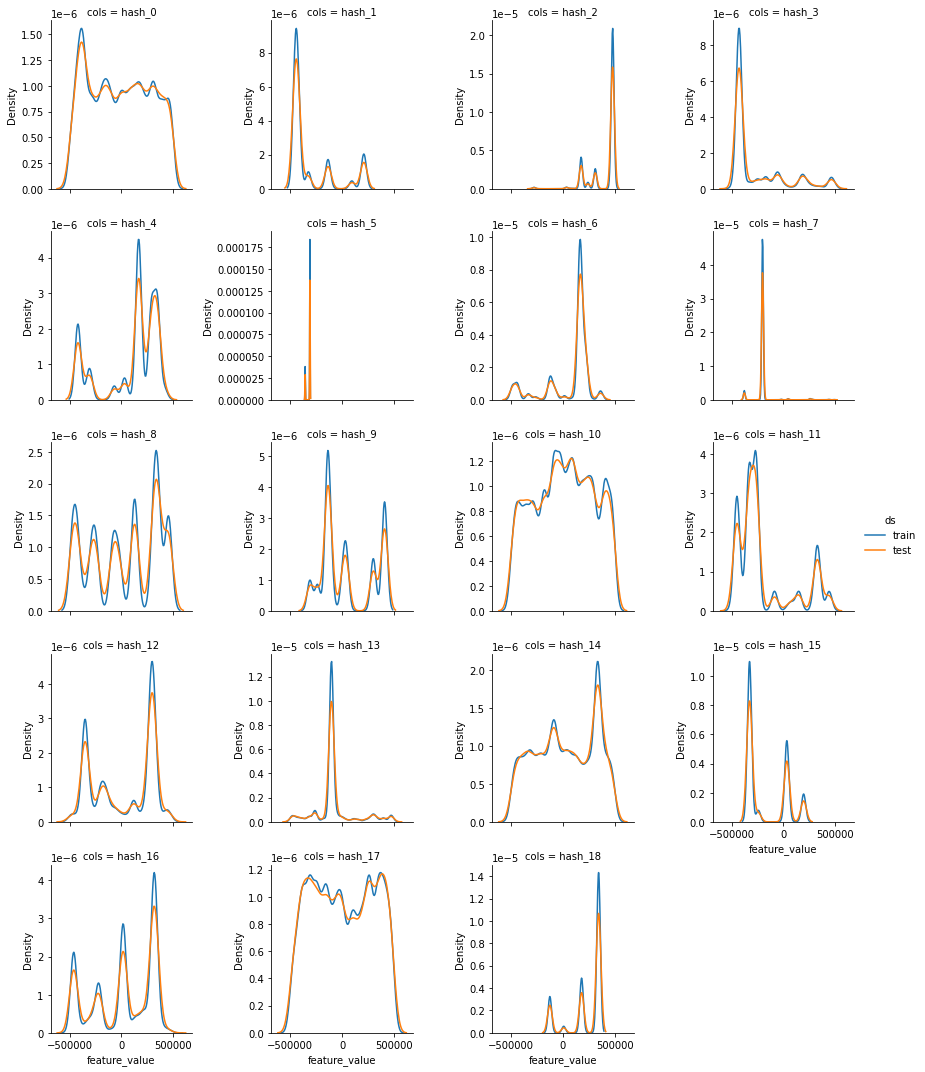

In [24]:
g = sns.FacetGrid(combined_data_long, col="cols", hue="ds", col_wrap=4, sharey=False)
g = g.map(sns.distplot, "feature_value", hist=False, rug=False)
g.add_legend()

From the plot above, we can see that the features are distributed similarly across both training and test datasets. 

# Feature Selection

In [113]:
# Map all categorical feature values to between (0, feature cardinality - 1)

enc_map = preprocessors.CategoricalMapper(config.FEATURES)
enc_cat = preprocessors.CategoricalTransformer(config.FEATURES)
train_data = enc_cat.fit_transform(enc_map.fit_transform(train_data))

In [114]:
train_data.head()

,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9,hash_10,hash_11,hash_12,hash_13,hash_14,hash_15,hash_16,hash_17,hash_18,click
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,0,0
2,2,2,1,0,2,1,1,0,2,2,2,2,2,0,2,2,0,2,1,0
3,3,1,0,2,0,1,2,0,3,3,3,0,3,2,3,0,1,3,0,0
4,4,2,2,0,2,1,1,0,4,4,4,0,4,0,4,0,1,4,2,0


To identify association between categorical features and a categorical target variable, the **chi square test of association** would be appropriate. 

The null hypothesis, to be tested is : 

\$H_{0}$: There is no association between the selected categorical column and target, i.e, they are independent. 

At a significance level ($\alpha$) of 95%, any categorical variable for which the p-value of the chi-square test is greater than 0.05 is considered to have no predictive power for the target variable. 


Columns **hash_0**, **hash_17**, **hash_10**, **hash_14** have been skipped over due to high cardinality

In [120]:
%%time 
result = utils.get_chisq_result(df=train_data, target=config.TARGET, skip= ['hash_0', 'hash_17', 'hash_10', 'hash_14'])

CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 232 ms


In [121]:
result

,col1,col2,p_value
0,hash_1,click,7.820449e-51
1,hash_2,click,7.820449e-51
2,hash_3,click,7.820449e-51
3,hash_4,click,7.820449e-51
4,hash_5,click,7.820449e-51
5,hash_6,click,7.820449e-51
6,hash_7,click,7.820449e-51
7,hash_8,click,7.820449e-51
8,hash_9,click,7.820449e-51
9,hash_11,click,7.820449e-51


From the results of the Chi-Squared test, all the features are considered to be relevant for predicting the target column

# Feature Encoding

Given that all the features in the dataset are categorical, and that some features in the dataset ( hash_0, hash_10, hash_17) have a high cardinality, all the feature columns will undergo the following transformations :- 

- Label Mapping :- To map all the categories between (0 , cardinality of the feature). 
- Target Encoding :- To replace each category in each feature with the mean target value of the **click** column. 

Label / Ordinal Encoding were not used as it is not clear from the dataset if there exists any ordinal relationship between different values of a categorical feature.
One Hot Encoding performs well for features with smaller cardinality, but creates sparse datasets and does not work very well with certain tree based models. 
